In [14]:
import gymnasium as gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self,**kwargs):
        self.step_n = 0
        return self.env.reset(**kwargs)

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)

        #一局游戏最多走N步
        self.step_n += 1
        if self.step_n >= 200:
            terminated = True

        return state, reward, terminated, truncated, info


env = MyWrapper()

env.reset()

(array([-0.04199954,  0.03019115, -0.04802198, -0.0398737 ], dtype=float32),
 {})

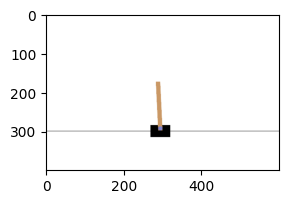

In [15]:
from matplotlib import pyplot as plt

%matplotlib inline


#打印游戏
def show():
    plt.figure(figsize=(3, 3))
    plt.imshow(env.render())
    plt.show()


show()

In [17]:
#认识游戏环境
def test_env():
    print('env.observation_space=', env.observation_space)
    print('env.action_space=', env.action_space)

    state,_ = env.reset()
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, info_ = env.step(action)

    print('state=', state)
    print('action=', action)
    print('next_state=', next_state)
    print('reward=', reward)
    print('done=', terminated)


test_env()

env.observation_space= Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
env.action_space= Discrete(2)
state= [ 0.04625071 -0.00627822 -0.03243756  0.01274021]
action= 0
next_state= [ 0.04612514 -0.20092031 -0.03218276  0.2950148 ]
reward= 1.0
done= False


In [18]:
#测试torch.distributions.Categorical
def test_dist():
    import torch

    #创建分布
    dist = torch.distributions.Categorical(torch.FloatTensor([0.2, 0.3, 0.5]))

    #从分布中采样
    action = dist.sample()
    print('action=', action)

    #计算概率的log
    log_prob = dist.log_prob(action)
    print('log_prob=', log_prob)
    
    
test_dist()

action= tensor(1)
log_prob= tensor(-1.2040)


In [20]:
import torch

#定义模型
class Model(torch.nn.Module):

    def __init__(self, device):
        super().__init__()
        self.device = device
        self.sequential = torch.nn.Sequential(torch.nn.Linear(4, 16),
                                              torch.nn.ReLU(),
                                              torch.nn.Linear(16, 2),
                                              torch.nn.Softmax(dim=1)).to(device)

    def forward(self, state):
        #[4] -> [1, 4]

        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        # print(state)

        #计算当前state下各个动作的概率
        #[1, 4] -> [1, 2]
        probs = self.sequential(state)
        #print("probs:",probs)
        
        #以概率创建分布
        dist = torch.distributions.Categorical(probs)

        #在概率中采样,获得action
        #scala
        action = dist.sample()
        # print("action:", action, "action:", action.item())

        #求动作的概率对数
        #scala
        log_prob = dist.log_prob(action)

        return action.item(), log_prob

# Usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(device)
model([1, 2, 3, 4]) # (batch_size, state_size, state )

(0, tensor([-0.8760], device='cuda:0', grad_fn=<SqueezeBackward1>))

In [21]:
#测试概率和entropy loss之间的关系
def test_loss(p0):
    #以概率创建分布
    dist = torch.distributions.Categorical(torch.FloatTensor([p0, 1 - p0]))

    log_probs = []
    for _ in range(20):
        #在概率中采样,获得action
        action = dist.sample()

        #求动作的概率对数
        log_prob = dist.log_prob(action)

        log_probs.append(log_prob)

    #动作的概率,取值是0-1,取对数后是-inf到0,符号取反之后是0到inf
    #这意味着loss越接近0,动作的概率越高,loss越大,动作的概率越低
    #动作本身也是从概率采样而来,所以概率越倾斜,loss越小.
    #也就是说[0.5,0.5]将导致大loss, [0.0,1.0]将导致小loss

    log_probs = torch.FloatTensor(log_probs)
    # print(log_probs)
    log_probs = -log_probs
    loss = log_probs.sum().item()

    return loss


for i in [0.5, 0.9, 0.9999]:
    print(i, test_loss(i))

0.5 13.862943649291992
0.9 2.107211112976074
0.9999 0.002000431763008237


In [22]:
from IPython import display
import random


#测试一局游戏,得到reward_sum
def test(play=False):
    state, _ = env.reset()
    reward_sum = 0
    terminated = False

    while not terminated:
        action, _ = model(state) # one batch one sample
        state, reward, terminated, truncated, info = env.step(action)
        reward_sum += reward

        if play and random.random() < 0.2:
            display.clear_output(wait=True)
            show()

    return reward_sum


sum([test() for _ in range(20)]) / 20

20.85

In [76]:
#训练
def train():
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    #训练200局游戏
    for i in range(200):
        #得到一局游戏的数据
        rewards = []
        log_probs = []
        state, _ = env.reset()
        terminated = False
        while not terminated:
            action, log_prob = model(state)
            state, reward, terminated, truncated, info = env.step(action)
            # print(state)

            #记录下rewards和log_probs
            rewards.append(reward)
            log_probs.append(log_prob)

        print(len(rewards))
        #[steps]
        rewards = torch.FloatTensor(rewards)
        #[steps]
        log_probs = torch.cat(log_probs)

        #对rewards进行decay后求和
        decay = torch.arange(len(rewards))
        #这里gamma写1.0意味着不decay, 0.95 is discounted ratio
        decay = 1**decay
        rewards *= decay
        dis_return = rewards.sum()
        print(dis_return)
        #考虑rewards和log_probs两部分loss,让两者相乘即可
        loss = dis_return * -log_probs.sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 200 == 0:
            print(i, sum([test() for _ in range(5)]) / 5)
            print("finish:", i)
        
        

    torch.save(model, 'save/3.Reinforce_CartPole')


train()

59
tensor(59.)
0 46.8
finish: 0
43
tensor(43.)
44
tensor(44.)
45
tensor(45.)
42
tensor(42.)
81
tensor(81.)
77
tensor(77.)
60
tensor(60.)
64
tensor(64.)
64
tensor(64.)
81
tensor(81.)
61
tensor(61.)
70
tensor(70.)
28
tensor(28.)
40
tensor(40.)
47
tensor(47.)
38
tensor(38.)
60
tensor(60.)
43
tensor(43.)
43
tensor(43.)
60
tensor(60.)
31
tensor(31.)
123
tensor(123.)
64
tensor(64.)
54
tensor(54.)
36
tensor(36.)
80
tensor(80.)
64
tensor(64.)
45
tensor(45.)
74
tensor(74.)
72
tensor(72.)
81
tensor(81.)
58
tensor(58.)
90
tensor(90.)
65
tensor(65.)
65
tensor(65.)
69
tensor(69.)
102
tensor(102.)
68
tensor(68.)
84
tensor(84.)
84
tensor(84.)
67
tensor(67.)
51
tensor(51.)
66
tensor(66.)
79
tensor(79.)
80
tensor(80.)
45
tensor(45.)
107
tensor(107.)
76
tensor(76.)
74
tensor(74.)
64
tensor(64.)
59
tensor(59.)
87
tensor(87.)
54
tensor(54.)
76
tensor(76.)
54
tensor(54.)
118
tensor(118.)
50
tensor(50.)
58
tensor(58.)
93
tensor(93.)
47
tensor(47.)
84
tensor(84.)
86
tensor(86.)
80
tensor(80.)
63
tensor(63.)


In [39]:
#对rewards进行decay后求和
decay = torch.arange(10)
print(decay)
#这里gamma写1.0意味着不decay
decay = 0.9**decay
decay

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


tensor([1.0000, 0.9000, 0.8100, 0.7290, 0.6561, 0.5905, 0.5314, 0.4783, 0.4305,
        0.3874])

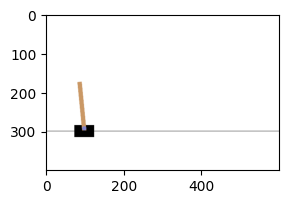

200.0

In [83]:
model = torch.load('save/3.Reinforce_CartPole')

#试玩
test(play=True)